[titanic_readme.txt](../_data/titanic_readme.txt)

[titanic_data.txt](../_data/titanic_data.txt)

# Exploratory Data Analysis (EDA)

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('../_data/titanic_data.txt')

# Data preaparation

In [5]:
df1 = df.copy()

In [6]:
# target vector
y = df1['Survived'].values
y.mean()

0.3838383838383838

In [7]:
df1['Age2'] = df['Age'].fillna(df['Age'].mean())

In [8]:
df1['Embarked2'] = df['Embarked'].fillna('?')

In [9]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
df1['Sex2'] = ord_enc.fit_transform(df[['Sex']])
df1['Embarked2'] = ord_enc.fit_transform(df1[['Embarked2']])

In [10]:
columns = ['Pclass', 'Sex2', 'Age2', 'SibSp', 'Parch', 'Fare', 'Embarked2']
X = df1[columns].values
X.mean()

9.756271143743692

- evaluation scheme: 5-fold cross-validation
- evaluation metric: accuracy score

In [11]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def evaluate(cl, X, y):
    cv = KFold(5, shuffle=True, random_state=42)
    scores = []
    for tr, te in cv.split(X, y):
        cl.fit(X[tr], y[tr])
        yhat = cl.predict(X)
        scores.append(accuracy_score(y[te], yhat[te]))
    return np.mean(scores)

In [12]:
# First the dummy classifier
evaluate(DummyClassifier(), X, y)

0.616194840248572

In [13]:
from sklearn.ensemble import HistGradientBoostingClassifier
evaluate(HistGradientBoostingClassifier(max_depth=5, random_state=42), X, y)

0.8350260498399347

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
evaluate(GradientBoostingClassifier(max_depth=4, random_state=42), X, y)

0.8294206264515724

In [15]:
from xgboost import XGBClassifier
evaluate(XGBClassifier(max_depth=4, random_state=42), X, y)

0.8238026489234824

In [16]:
from sklearn.linear_model import LogisticRegression
evaluate(LogisticRegression(random_state=42, max_iter=2000), X, y)

0.8002134203753688

In [17]:
from sklearn.ensemble import RandomForestClassifier
evaluate(RandomForestClassifier(random_state=42), X, y)

0.821568012051974

In [18]:
from sklearn.ensemble import ExtraTreesClassifier
evaluate(ExtraTreesClassifier(random_state=42), X, y)

0.8002134203753688

In [19]:
# LGBMClassifier
from lightgbm import LGBMClassifier
evaluate(LGBMClassifier(boosting_type='goss', max_depth=10, random_state=42), X, y)

0.8406377502981609

# Ivestigating the Models

In [20]:
from sklearn.ensemble import RandomForestClassifier
rf2 = RandomForestClassifier(random_state=42, max_depth=11)
rf2.fit(X, y)

RandomForestClassifier(max_depth=11, random_state=42)

In [21]:
pd.Series(rf2.feature_importances_, columns).sort_values()[::-1]

Sex2         0.295348
Fare         0.250201
Age2         0.226667
Pclass       0.098358
SibSp        0.053608
Parch        0.040493
Embarked2    0.035325
dtype: float64

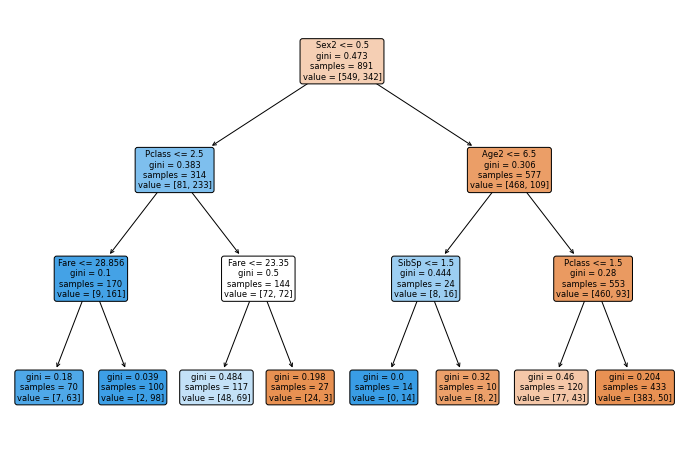

In [22]:
# Build a simple model (shallow decision tree) and visualize it.
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

cl = DecisionTreeClassifier(max_depth=3, random_state=42, min_samples_leaf=10)
cl.fit(X, y)

plt.figure(figsize=(12, 8))
plot_tree(cl, filled=True, rounded=True, feature_names=columns)
pass

In [23]:
# Error analysis.
yhat = rf2.predict_proba(X)[:, 1]
df['yhat'] = yhat

# False positives
df_fp = df[(yhat > 0.5) & (y == 0)].sort_values('yhat')[::-1]

# False negative
df_fn = df[(yhat <= 0.5) & (y == 1)].sort_values('yhat')

In [24]:
# FP #1
df_fp.iloc[0]

PassengerId                   265
Survived                        0
Pclass                          3
Name           Henry, Miss. Delia
Sex                        female
Age                           NaN
SibSp                           0
Parch                           0
Ticket                     382649
Fare                         7.75
Cabin                         NaN
Embarked                        Q
yhat                     0.826134
Name: 264, dtype: object

In [25]:
# FP #2
df_fp.iloc[1]

PassengerId             827
Survived                  0
Pclass                    3
Name           Lam, Mr. Len
Sex                    male
Age                     NaN
SibSp                     0
Parch                     0
Ticket                 1601
Fare                56.4958
Cabin                   NaN
Embarked                  S
yhat               0.585247
Name: 826, dtype: object

In [27]:
df_fn.iloc[0]

PassengerId                       108
Survived                            1
Pclass                              3
Name           Moss, Mr. Albert Johan
Sex                              male
Age                               NaN
SibSp                               0
Parch                               0
Ticket                         312991
Fare                            7.775
Cabin                             NaN
Embarked                            S
yhat                         0.124266
Name: 107, dtype: object

In [28]:
df_fn.iloc[1]

PassengerId                             829
Survived                                  1
Pclass                                    3
Name           McCormack, Mr. Thomas Joseph
Sex                                    male
Age                                     NaN
SibSp                                     0
Parch                                     0
Ticket                               367228
Fare                                   7.75
Cabin                                   NaN
Embarked                                  Q
yhat                               0.133598
Name: 828, dtype: object